In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import mira
import matplotlib.pyplot as plt

In [92]:
data = anndata.read_h5ad('data/analysis/ascl1_rna_data.h5ad')

mindata = anndata.AnnData(
    obs = pd.DataFrame(index = data.obs_names.values),
    obsm = {'X_joint_umap_features' : data.obsm['X_joint_umap_features'], 'X_umap' : data.obsm['X_umap']},
)

In [94]:
sc.pp.neighbors(mindata, use_rep='X_joint_umap_features', metric='manhattan')

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

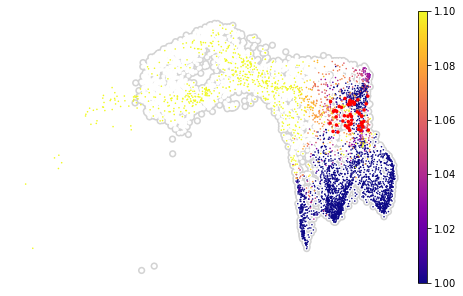

In [3]:
late_prog_cells = (data.obs.mira_pseudotime > 16) & (data.obs.mira_pseudotime < 16.2)\
    & (data.obs.differentiation_entropy > 0.9) & (data.obs.differentiation_entropy < 1.2) &\
    (data.obsm['X_umap'][:,1] < 5) & (data.obsm['X_umap'][:,1] > 4.5)

fig, ax = plt.subplots(1,1,figsize=(8,5))
sc.pl.umap(data[data.obs.mira_pseudotime > 5], na_color= 'white', add_outline=True, frameon=False, 
           show = False, ax = ax, outline_color=('lightgrey','white'), outline_width=(1, 0.8), size = 10)
sc.pl.umap(data[data.obs.time == 'PS6'], color = 'differentiation_entropy', color_map='plasma', size = 10,
          vmin = 1., vmax = 1.1, frameon=False, show = False, ax = ax)
sc.pl.umap(data[late_prog_cells], na_color='red', size = 50, frameon=False, show = False, ax = ax)

INFO:mira.pseudotime.backtrace:Creating transport map ...
/Users/alynch/projects/multiomics/mira/mira/mira/pseudotime/pseudotime.py:301: RuntimeWarning: divide by zero encountered in true_divide
  inverse_rowsums = sparse.diags(1/np.array(affinity_matrix.sum(axis = 1)).reshape(-1)).tocsr()
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


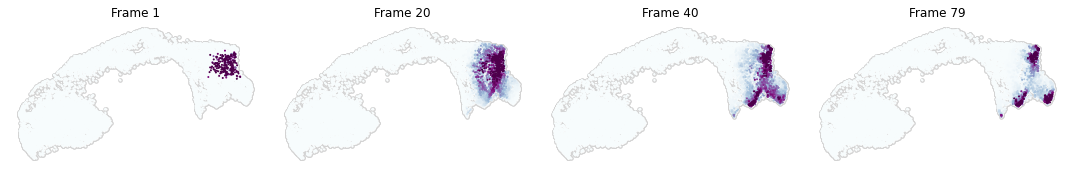

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [5]:
mira.time.trace_differentiation(data, start_cells=late_prog_cells.values,
                      num_steps=400, steps_per_frame=5, save_name='data/analysis/2022-01-15_late_progenitor_differeniation_sim.gif',
                     direction='forward', ka = 2, log_prob = True, vmax_quantile=0.99,
                     fps=24, log_time=True)

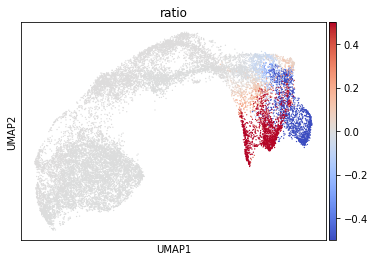

In [13]:
data.obs['ratio'] = np.log(data.obs.MYO3A_prob/data.obs.PAX6_prob) - \
    np.log(data[data.uns['start_cell']].obs.MYO3A_prob/data[data.uns['start_cell']].obs.PAX6_prob).values

sc.pl.umap(data, color = 'ratio', vmin = -0.5, vmax = 0.5, color_map='coolwarm')

INFO:mira.pseudotime.backtrace:Creating transport map ...
/Users/alynch/projects/multiomics/mira/mira/mira/pseudotime/pseudotime.py:301: RuntimeWarning: divide by zero encountered in true_divide
  inverse_rowsums = sparse.diags(1/np.array(affinity_matrix.sum(axis = 1)).reshape(-1)).tocsr()
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


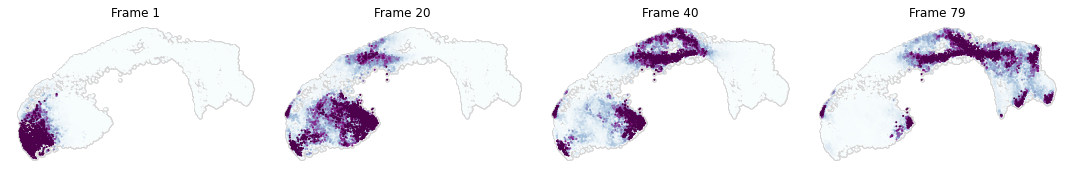

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [7]:
trace_differentiation(data, start_cells=data.obs.mira_pseudotime.values.argsort().argsort() < 20,
                      num_steps=2000, steps_per_frame=25, save_name='data/analysis/test.gif',
                     direction='forward', ka = , log_prob = True, vmax_quantile=0.93,
                     fps=10, log_time=False)

In [96]:
data = mindata

In [97]:
sc.tl.diffmap(data)
mira.time.normalize_diffmap(data)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 2 diffusion map components.


/Users/alynch/projects/multiomics/mira/mira/mira/plots/eigengap_plot.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(range(len(eigvals)-1), eigvals[1:], '--bo', c = 'black')


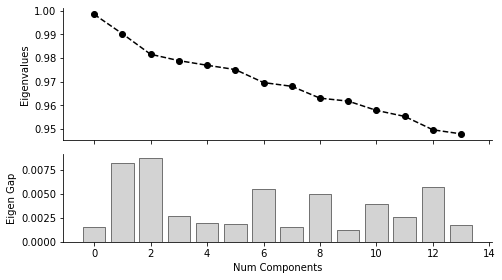

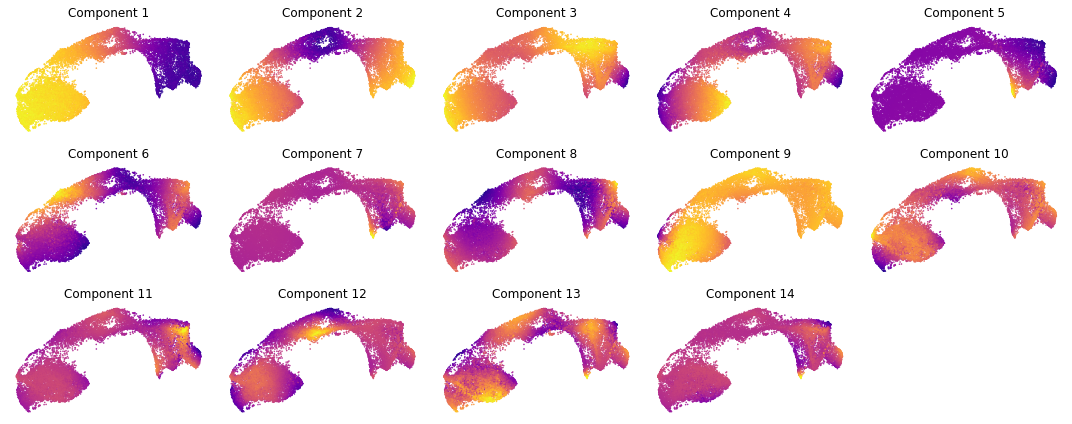

In [98]:
mira.pl.plot_eigengap(data)
plt.show()

In [99]:
sc.pp.neighbors(data, use_rep='X_diffmap', n_pcs = 6, key_added='X_diffmap')
mira.time.get_connected_components(data)

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


In [100]:
mira.time.get_transport_map(data, start_cell= int(data.obsm['X_diffmap'][:,0].argmax()),
                            n_jobs=4)

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
Calculating pseudotime:   4%|███████▍                                                                                                                                                                                  | 2646/66150 [00:01<00:31, 2034.18it/s]
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
/Users/alynch/projects/multiomics/mira/mira/mira/pseudotime/pseudotime.py:301: RuntimeWarning: divide by zero encountered in true_divide
  assert(np.all(indptr[1:] - indptr[0:-1] == k)), 'distance matrix is not a valid Knn matrix. Different numbers of neighbors for each cell.'
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


In [101]:
terminal_cells = mira.time.find_terminal_cells(data, threshold=1e-2)

INFO:mira.pseudotime.pseudotime:Found 5 terminal states from stationary distribution.


In [102]:
terminal_cells = ['CAGGTGGAGTTGGGCC-PS6', 'TCGTTAGCATCATGGC-PS6',
       'TAGCAGGCATAAGGAC-PS6', 'ACGTCCTTCAGGCTAT-PS6']

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mira_connected_components' as categorical


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

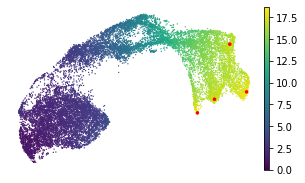

In [103]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
sc.pl.umap(data, color = 'mira_pseudotime', frameon = False, 
    show = False, ax = ax)
sc.pl.umap(data[terminal_cells], na_color = 'Red', frameon = False,
    show = False, ax = ax, size = 50)

In [104]:
mira.time.get_branch_probabilities(data, terminal_cells=
                                  dict(zip('ABCD',terminal_cells)))

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: A_prob
INFO:mira.adata_interface.core:Added cols to obs: B_prob
INFO:mira.adata_interface.core:Added cols to obs: C_prob
INFO:mira.adata_interface.core:Added cols to obs: D_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical


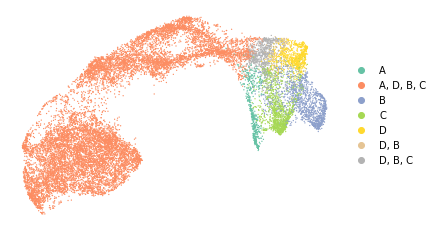

In [105]:
mira.time.get_tree_structure(data, threshold = 0.51)
sc.pl.umap(data, color = 'tree_states', palette = 'Set2', frameon = False, title = '')

INFO:mira.pseudotime.backtrace:Creating transport map ...
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


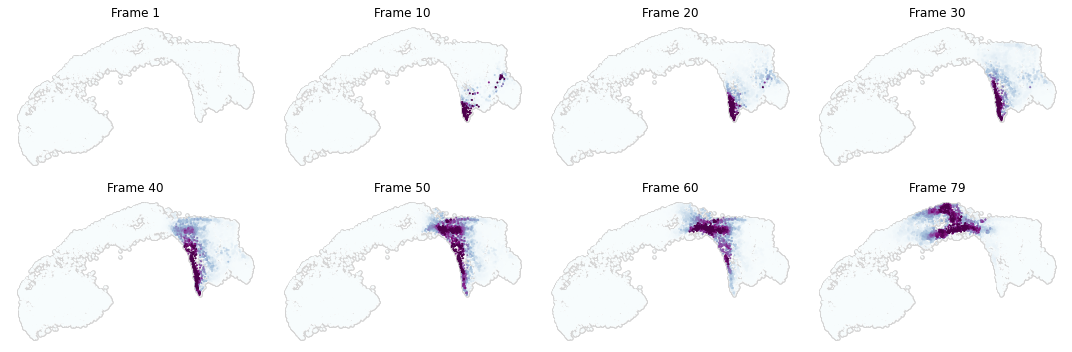

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [77]:
mira.time.trace_differentiation(data, start_lineage='A', ka=2, num_start_cells=50,
                               log_prob=True, log_time=True, save_name='data/analysis/ascl1_backtrack.gif',
                                direction='backward', num_preview_frames=8, num_steps=800, steps_per_frame=10)

In [108]:
!mkdir data/docdata

In [109]:
data.write_h5ad('data/docdata/pratik_2020.h5ad')

In [110]:
mira.pl.plot_stream(data, data = 'ASCL1', log_pseudotime=False, window_size=301)

KeyError: 'Could not find key ASCL1 in .var_names or .obs.columns.'